<a href="https://colab.research.google.com/github/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/notebooks/Clasificaci%C3%B3n_Pok%C3%A9mons_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Visualization
# import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configuración del notebook
# cf.go_offline()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

# Librerías adicionales
import shutil
import os
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output

class CustomLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomLogger, self).__init__()
        self.epoch_logs = []
        self.best_val_accuracy = 0  # Variable para almacenar el mejor val_accuracy
        self.best_epoch_log = {}     # Variable para almacenar los logs del mejor epoch
        self.best_epoch_index = 0    # Variable para almacenar el índice del mejor epoch

    def on_epoch_end(self, epoch, logs=None):
        # Guardar los logs de la época actual
        self.epoch_logs.append(logs)

        # Actualizar el mejor val_accuracy y el log correspondiente
        current_val_accuracy = logs.get('val_accuracy')
        if current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.best_epoch_log = logs.copy()  # Almacenar el log del mejor epoch
            self.best_epoch_index = epoch

        # Mantener solo las últimas 5 épocas
        if len(self.epoch_logs) > 5:
            self.epoch_logs.pop(0)

        # Limpiar la salida anterior
        clear_output(wait=True)

        # Mostrar las últimas 5 épocas
        print("\nÚltimas 5 épocas:")
        for i, log in enumerate(self.epoch_logs):
            epoch_num = epoch - len(self.epoch_logs) + i + 1
            rounded_log = {k: round(v, 4) for k, v in log.items()}  # Redondear los valores de logs
            print(f'Epoch {epoch_num}: {rounded_log}')

        # Mostrar el log de la mejor época
        rounded_best_log = {k: round(v, 4) for k, v in self.best_epoch_log.items()}  # Redondear el mejor log
        print("\nMejor Epoch:")
        print(f'Epoch {self.best_epoch_index} (val_accuracy={round(self.best_val_accuracy, 4):.4f}): {rounded_best_log}')


def copy_images(data, folder_name, images_dir):
    for _, row in data.iterrows():
        name = row["Name"]
        type1 = row["Type1"]

        # Construir las rutas de los archivos de origen para ambos formatos
        png_source_file = os.path.join(images_dir, f"{name}.png")
        jpg_source_file = os.path.join(images_dir, f"{name}.jpg")

        # Construir la ruta del archivo de destino
        dest_dir = os.path.join(folder_name, type1)

        # Copiar el archivo PNG si existe
        if os.path.exists(png_source_file):
            dest_file = os.path.join(dest_dir, f"{name}.png")
            shutil.copy(png_source_file, dest_file)
        # Copiar el archivo JPG si existe
        elif os.path.exists(jpg_source_file):
            dest_file = os.path.join(dest_dir, f"{name}.jpg")
            shutil.copy(jpg_source_file, dest_file)
        else:
            print(f"El archivo {name} no existe en formato PNG o JPG.")


def display_sample_images(df, image_folder, num_images=16, rows=4, cols=4):
    """"""
    # Selecciona un muestreo aleatorio de imágenes
    sampled_images = df["Name"].sample(n=num_images).tolist()

    # Configura el tamaño de la figura
    fig = plt.gcf()
    fig.set_size_inches(24, 24)
    plt.figure(figsize=(12, 10), dpi=80)

    # Mostrar las imágenes
    for i, img_name in enumerate(sampled_images):
        # Probar ambas extensiones
        img_paths = [
            os.path.join(image_folder, f"{img_name}.jpg"),
            os.path.join(image_folder, f"{img_name}.png")
        ]

        img_path = None
        for path in img_paths:
            if os.path.exists(path):
                img_path = path
                break

        # Si se encuentra la imagen, se muestra
        if img_path:
            sp = plt.subplot(rows, cols, i + 1)
            sp.axis("Off")
            img = mpimg.imread(img_path)
            sp.set_title(os.path.basename(img_path), fontsize=6)
            plt.imshow(img)
        else:
            print(f"No se encontró la imagen para: {img_name}")

    plt.tight_layout()
    plt.show()


def remove_transparency_add_background(image_path, output_path, background_color=(255, 255, 255)):
    # Abre la imagen
    image = Image.open(image_path)

    # Verifica si tiene un canal alfa (RGBA)
    if image.mode in ('P'):  # 'P' es para imágenes de paleta
        image = image.convert('RGBA')

    if image.mode == "RGBA":
        # Crear una imagen de fondo con el color especificado (blanco por defecto) y en modo RGBA
        background = Image.new('RGBA', image.size, background_color + (255,))  # Fondo blanco con canal alfa completo
        # Combinar la imagen con el fondo
        image_rgb = Image.alpha_composite(background, image)
        image_rgb = image_rgb.convert('RGB')  # Convertir a RGB para eliminar el canal alfa
        image_rgb.save(output_path)  # Guardar la nueva imagen sin transparencia
    else:
        # Si la imagen no tiene transparencia (RGB), simplemente la guardamos como está
        image.convert('RGB').save(output_path)  # Asegurar que se guarda en formato RGB

def process_images(input_folder, output_folder):
    # Crear la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # Recorrer todos los archivos de la carpeta de entrada
    for filename in tqdm(files, desc="Procesando imágenes"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            try:
                remove_transparency_add_background(image_path, output_path)
            except Exception as e:
                print(f'Error al procesar {filename}: {e}')

## Preparación de las carpetas

In [13]:
!rm -rf Pokémons
!rm -f pokemons.zip && wget https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/data/Pok%C3%A9mons.zip?raw=true -O pokemons.zip
!unzip pokemons.zip > /dev/null

--2024-10-08 05:05:58--  https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/data/Pok%C3%A9mons.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/raw/refs/heads/main/data/Pok%C3%A9mons.zip [following]
--2024-10-08 05:05:58--  https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/raw/refs/heads/main/data/Pok%C3%A9mons.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/refs/heads/main/data/Pok%C3%A9mons.zip [following]
--2024-10-08 05:05:58--  https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/refs/heads/main/data/Pok%C3%A9mons.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.13

## Estableciendo las rutas

In [14]:
# Main
main_dir = "Pokémons/dataset"
# Metadata
metadata_dir = os.path.join(main_dir, "pokemon.csv")
# Imágenes
images_dir = os.path.join(main_dir, "images")
images_processed_dir = os.path.join(main_dir, "images_processed")
# Train, Validation, Test
train_dir = os.path.join(main_dir, "train")
validation_dir = os.path.join(main_dir, "validation")
test_dir = os.path.join(main_dir, "test")

## Manejo de las transparencias

In [15]:
process_images(images_dir, images_processed_dir)

Procesando imágenes: 100%|██████████| 809/809 [00:01<00:00, 687.10it/s]


## Análisis de la metadata

In [16]:
df = pd.read_csv(metadata_dir)
print(f"Tamaño del DataFrame: {df.shape}")
df.head()

Tamaño del DataFrame: (809, 3)


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [17]:
count_df = df.value_counts("Type1").reset_index()
count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Type1,Water,Normal,Grass,Bug,Psychic,Fire,Rock,Electric,Poison,Ground,Dark,Fighting,Dragon,Ghost,Steel,Ice,Fairy,Flying
count,114,105,78,72,53,53,46,40,34,32,29,29,27,27,26,23,18,3


**Nota:** Hay pocos registros para Fairy y Flying

In [18]:
threshold = 20
types_with_few_samples = count_df[count_df["count"] < threshold]["Type1"].to_list()
types_with_few_samples

['Fairy', 'Flying']

In [19]:
# Agregando más datos para Fairy y Flying
n_samples = 20
sampled_df = pd.DataFrame()
for pokemon_type in types_with_few_samples:
  tmp_df = df[df["Type2"] == pokemon_type].sample(n_samples, random_state=42)
  tmp_df.loc[:, "Type1"] = tmp_df["Type2"]

  if sampled_df.empty:
        sampled_df = tmp_df
  else:
        sampled_df = pd.concat([sampled_df, tmp_df])

df = pd.concat([df, sampled_df]).reset_index(drop=True)
df[df["Type1"].isin(types_with_few_samples)].value_counts("Type1")

,count
Type1,
Fairy,38
Flying,23


In [20]:
# df1 = df[['Name', 'Type1']]
# df2 = df[['Name', 'Type2']].dropna()

# df = pd.concat([df1, df2.rename(columns={'Type2': 'Type1'})], ignore_index=True)

# print(new_df.shape)
# new_df.head()

## Train, Validation & Test

In [21]:
from re import X
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en train y un conjunto temporal (test + validation)
train_df, temp_df = train_test_split(
    df, test_size=0.4, random_state=42, stratify=df["Type1"]
)

# Dividir el conjunto temporal en test y validation
test_df, validation_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["Type1"]
)

**Tamaño de los conjuntos de datos**

In [22]:
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(validation_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 509
Tamaño del conjunto de validación: 170
Tamaño del conjunto de prueba: 170


## Organizando imágenes en train, validation y test

In [23]:
for folder in [train_dir, test_dir, validation_dir]:
    os.makedirs(folder, exist_ok=True)
    # Crear subcarpetas para cada Type1
    for type1 in pd.concat([train_df, test_df, validation_df])["Type1"].unique():
        os.makedirs(os.path.join(folder, type1), exist_ok=True)

In [24]:
copy_images(train_df, train_dir, images_processed_dir)
copy_images(test_df, test_dir, images_processed_dir)
copy_images(validation_df, validation_dir, images_processed_dir)

## Visualización de pokémons

<Figure size 2400x2400 with 0 Axes>

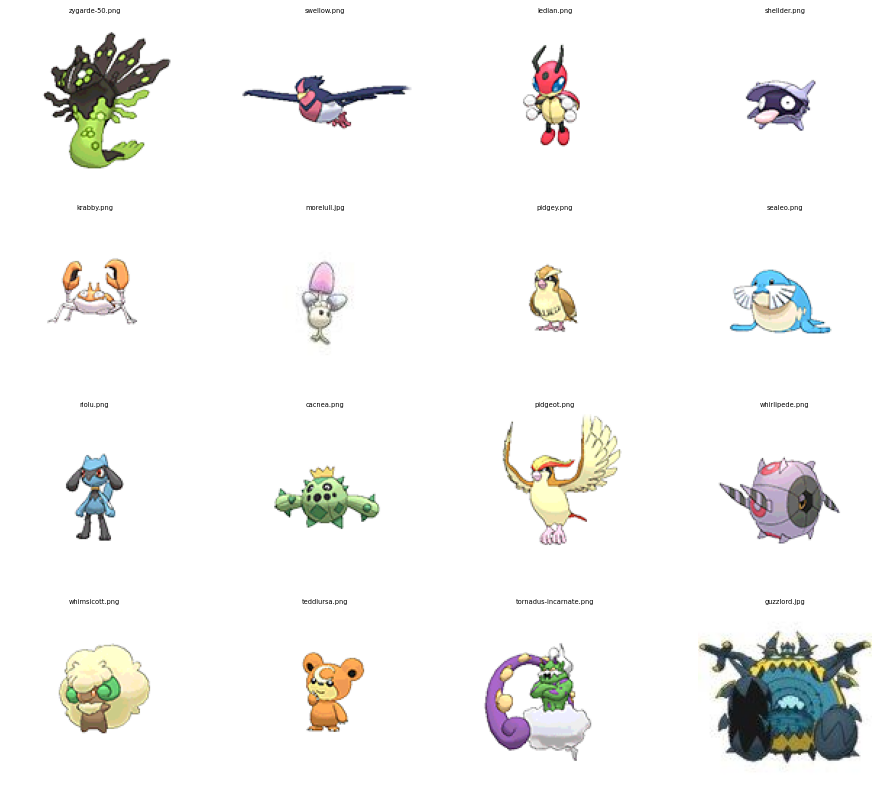

In [25]:
display_sample_images(df, images_processed_dir, num_images=16, rows=4, cols=4)

## Modelación

In [26]:
dgen_train = ImageDataGenerator(
    rescale=1./255,  # Normalización de las imágenes
    rotation_range=40,  # Rotación aleatoria
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.2,  # Corte aleatorio
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest'  # Modo de relleno
)
dgen = ImageDataGenerator(rescale=1./255)

In [27]:
TARGET_SIZE = (120, 120)
BATCH_SIZE = 32
CLASS_MODE = 'categorical'

In [28]:
train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)

validation_generator = dgen.flow_from_directory(validation_dir,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode=CLASS_MODE)

test_generator = dgen.flow_from_directory(test_dir,
                                          target_size=TARGET_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode=CLASS_MODE)

Found 509 images belonging to 18 classes.
Found 170 images belonging to 18 classes.
Found 170 images belonging to 18 classes.


### Modelo Base

- 3 capas convolucionales
- Sin Dropout
- learning rate de 0.0001

In [43]:
model = Sequential()

model.add(Input(shape=(120, 120, 3)))
# Capa convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar la salida para la capa densa
model.add(Flatten())

# Capa densa
model.add(Dense(128, activation='relu'))

# Capa de salida
model.add(Dense(18, activation='softmax'))

# Crear el logger
custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 59, 59, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 28, 28, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 13, 13, 128)      

### Modelo Mejorado 1A
- 3 capas convolucionales
- Con ReLu como funcion de activacion
- Con Dropout en capa densa
- Kernel de 5 en primer capa
- learning rate de 0.0001

In [ ]:
from tensorflow.keras.layers import Activation
model = Sequential()
# Capa de entrada
model.add(Input(shape=(120, 120, 3)))
# Capa convolucional 1
model.add(Conv2D(32, (5, 5)))
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2)))
# Capa convolucional 2
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2)))
# Capa convolucional 3
model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2)))
# Aplanar la salida para la capa densa
model.add(Flatten())
# Capa densa
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Capa de salida
model.add(Dense(18, activation='softmax'))

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)

### Modelo Mejorado 1B
- 3 capas convolucionales
- Con LeakyReLU como funcion de activacion
- Con Dropout en capa densa
- Kernel de 5 en primer capa
- learning rate de 0.0001

In [57]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, LeakyReLU

model = Sequential()
# Capa de entrada
model.add(Input(shape=(120, 120, 3)))
# Capa convolucional 1
model.add(Conv2D(32, (5, 5)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
# Capa convolucional 2
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
# Capa convolucional 3
model.add(Conv2D(128, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
# Aplanar la salida para la capa densa
model.add(Flatten())
# Capa densa
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Capa de salida
model.add(Dense(18, activation='softmax'))

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Últimas 5 épocas:
Epoch 58: {'loss': 2.1978, 'accuracy': 0.3143, 'val_loss': 2.6904, 'val_accuracy': 0.2647}
Epoch 59: {'loss': 2.1553, 'accuracy': 0.3399, 'val_loss': 2.5928, 'val_accuracy': 0.2941}
Epoch 60: {'loss': 2.1639, 'accuracy': 0.3261, 'val_loss': 2.7153, 'val_accuracy': 0.2529}
Epoch 61: {'loss': 2.1358, 'accuracy': 0.336, 'val_loss': 2.9024, 'val_accuracy': 0.2412}
Epoch 62: {'loss': 2.1374, 'accuracy': 0.3497, 'val_loss': 2.5373, 'val_accuracy': 0.2765}

Mejor Epoch:
Epoch 42 (val_accuracy=0.2941): {'loss': 2.2667, 'accuracy': 0.3045, 'val_loss': 2.5869, 'val_accuracy': 0.2941}


### Modelo Mejorado 2
- 3 capas convolucionales
- Con Dropout (0.2) en capa densa
- Kernel de 7 en primer y segunda capa
- learning rate de 0.0001

In [52]:
model = Sequential()

model.add(Input(shape=(120, 120, 3)))
# Capa convolucional 1
model.add(Conv2D(32, (7, 7), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 2
model.add(Conv2D(64, (7, 7), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar y agregar capas densas
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(18, activation='softmax'))

model.summary()

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Últimas 5 épocas:
Epoch 29: {'loss': 2.4007, 'accuracy': 0.2809, 'val_loss': 2.5105, 'val_accuracy': 0.2471}
Epoch 30: {'loss': 2.4147, 'accuracy': 0.277, 'val_loss': 2.5005, 'val_accuracy': 0.2588}
Epoch 31: {'loss': 2.4104, 'accuracy': 0.2809, 'val_loss': 2.5018, 'val_accuracy': 0.2471}
Epoch 32: {'loss': 2.3706, 'accuracy': 0.2947, 'val_loss': 2.5804, 'val_accuracy': 0.2471}
Epoch 33: {'loss': 2.3916, 'accuracy': 0.2711, 'val_loss': 2.6594, 'val_accuracy': 0.1882}

Mejor Epoch:
Epoch 13 (val_accuracy=0.2765): {'loss': 2.6077, 'accuracy': 0.2122, 'val_loss': 2.5589, 'val_accuracy': 0.2765}


### Modelo Mejorado 3
- 4 capas convolucionales
- Con Dropout en capa densa
- Kernel de 5 en primer capa y segunda capa
- learning rate de 0.0001

In [55]:
model = Sequential()

# Capa de entrada
model.add(Input(shape=(120, 120, 3)))

# Primer bloque convolucional
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))  # Aumentar de 32 a 64 filtros
model.add(MaxPooling2D((2, 2)))

# Segundo bloque convolucional
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))  # Aumentar de 64 a 128 filtros
model.add(MaxPooling2D((2, 2)))

# Tercer bloque convolucional
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))  # Aumentar de 128 a 256 filtros
model.add(MaxPooling2D((2, 2)))

# Cuarto bloque convolucional
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))  # Aumentar de 256 a 512 filtros
model.add(MaxPooling2D((2, 2)))

# Aplanar y agregar capas densas
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))  # Regularización

# Capa de salida
model.add(Dense(18, activation='softmax'))  # 18 categorías

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Últimas 5 épocas:
Epoch 24: {'loss': 2.4334, 'accuracy': 0.2495, 'val_loss': 2.5273, 'val_accuracy': 0.2471}
Epoch 25: {'loss': 2.4568, 'accuracy': 0.2515, 'val_loss': 2.5212, 'val_accuracy': 0.2059}
Epoch 26: {'loss': 2.3925, 'accuracy': 0.2672, 'val_loss': 2.5137, 'val_accuracy': 0.2412}
Epoch 27: {'loss': 2.3718, 'accuracy': 0.2731, 'val_loss': 2.723, 'val_accuracy': 0.1882}
Epoch 28: {'loss': 2.3402, 'accuracy': 0.2829, 'val_loss': 2.5844, 'val_accuracy': 0.2176}

Mejor Epoch:
Epoch 8 (val_accuracy=0.2471): {'loss': 2.6757, 'accuracy': 0.1847, 'val_loss': 2.6309, 'val_accuracy': 0.2471}


### Modelo Mejorado 4
- 4 capas convolucionales
- Con Dropout en capa densa
- Kernel de 3 en primer capa
- learning rate de 0.0001

In [56]:
model = Sequential()

# Capa de entrada
model.add(Input(shape=(120, 120, 3)))

# Primer bloque convolucional
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # Aumentar de 32 a 64 filtros
model.add(MaxPooling2D((2, 2)))

# Segundo bloque convolucional
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))  # Aumentar de 64 a 128 filtros
model.add(MaxPooling2D((2, 2)))

# Tercer bloque convolucional
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))  # Aumentar de 128 a 256 filtros
model.add(MaxPooling2D((2, 2)))

# Cuarto bloque convolucional
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))  # Aumentar de 256 a 512 filtros
model.add(MaxPooling2D((2, 2)))

# Aplanar y agregar capas densas
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))  # Regularización

# Capa de salida
model.add(Dense(18, activation='softmax'))  # 18 categorías

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Últimas 5 épocas:
Epoch 72: {'loss': 2.5481, 'accuracy': 0.2456, 'val_loss': 2.5329, 'val_accuracy': 0.2235}
Epoch 73: {'loss': 2.5428, 'accuracy': 0.2358, 'val_loss': 2.542, 'val_accuracy': 0.2353}
Epoch 74: {'loss': 2.513, 'accuracy': 0.2397, 'val_loss': 2.5652, 'val_accuracy': 0.2412}
Epoch 75: {'loss': 2.5296, 'accuracy': 0.2358, 'val_loss': 2.526, 'val_accuracy': 0.2353}
Epoch 76: {'loss': 2.5236, 'accuracy': 0.2358, 'val_loss': 2.5432, 'val_accuracy': 0.2294}

Mejor Epoch:
Epoch 56 (val_accuracy=0.2588): {'loss': 2.6166, 'accuracy': 0.2102, 'val_loss': 2.5592, 'val_accuracy': 0.2588}


### Modelo Mejorado 5
- 4 capas convolucionales
- Con Dropout en capa densa
- Kernel de 7 en primer capa y 5 kernels en segunda capa
- learning rate de 0.0001

In [58]:
# Probando con un learning rate más grande

model = Sequential()

# Capa de entrada
model.add(Input(shape=(120, 120, 3)))

# Primer bloque convolucional
model.add(Conv2D(64, (7, 7), activation='relu', padding='same'))  # Aumentar de 32 a 64 filtros
model.add(MaxPooling2D((2, 2)))

# Segundo bloque convolucional
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))  # Aumentar de 64 a 128 filtros
model.add(MaxPooling2D((2, 2)))

# Tercer bloque convolucional
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))  # Aumentar de 128 a 256 filtros
model.add(MaxPooling2D((2, 2)))

# Cuarto bloque convolucional
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))  # Aumentar de 256 a 512 filtros
model.add(MaxPooling2D((2, 2)))

# Aplanar y agregar capas densas
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))  # Regularización

# Capa de salida
model.add(Dense(18, activation='softmax'))  # 18 categorías

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Últimas 5 épocas:
Epoch 71: {'loss': 1.7872, 'accuracy': 0.4322, 'val_loss': 2.7169, 'val_accuracy': 0.2882}
Epoch 72: {'loss': 1.8033, 'accuracy': 0.4106, 'val_loss': 2.9245, 'val_accuracy': 0.2588}
Epoch 73: {'loss': 1.7441, 'accuracy': 0.4342, 'val_loss': 2.938, 'val_accuracy': 0.2471}
Epoch 74: {'loss': 1.822, 'accuracy': 0.4008, 'val_loss': 2.8885, 'val_accuracy': 0.2765}
Epoch 75: {'loss': 1.7519, 'accuracy': 0.4499, 'val_loss': 2.9273, 'val_accuracy': 0.2588}

Mejor Epoch:
Epoch 63 (val_accuracy=0.3294): {'loss': 1.9329, 'accuracy': 0.3811, 'val_loss': 2.687, 'val_accuracy': 0.3294}


KeyboardInterrupt: 

### Modelo Mejorado 6

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten

model = Sequential()
model.add(Input(shape=(120, 120, 3)))

# Capa convolucional 1
model.add(Conv2D(32, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Capa convolucional 2
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Capa convolucional 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Aplanado y capas densas
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Capa de salida
model.add(Dense(18, activation='softmax'))

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)